# Import libraries and packages

In [2]:
import os
import csv
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# MNIST digits dataset

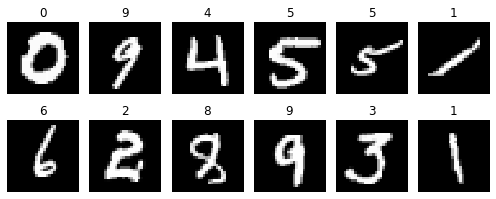

In [20]:
dataset = pd.read_csv('./dataset/mnist_digits.csv')
rand_idx = np.random.choice(dataset.index, size=100, replace=False)
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(7,3))
def pixel_mat(row):
    vec = dataset.drop('label', axis=1).iloc[row].values
    pixel_mat = vec.reshape(28,28)
    return pixel_mat

i = 0
for ax in axs.reshape(-1):
    ax.set_title("{}".format(dataset['label'].iloc[rand_idx[i]]))
    ax.imshow(pixel_mat(rand_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    ax.axis('off')
    i += 1
plt.tight_layout()   
plt.show()

# Model selection and hyper-parameters definition  

In [5]:
def get_data():
    dataset_path = "./dataset/mnist_digits.csv"
    df = pd.read_csv(dataset_path)
    df = df.head(1000)
    X = df.drop('label', axis=1) 
    X = X / 255
    y = df["label"].copy()
    return (X, y)
    

In [6]:
def get_estimator():
    return MLPClassifier(random_state=42)

In [7]:
def get_hyperparams():
    return {
        'hidden_layer_sizes': [25, 50, 100, 150, 200],
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.001, 0.01, 0.1],
        'learning_rate': ['adaptive', 'constant']
    }

# Experiment Class

In [8]:
class Experiment: 
    """
        # Name of the Search algorithm used for opitmization
        # Search algorithm used for opitmization
    """
    def __init__(self, search_name:str, search_algo):        
        self.search_name = search_name        
        self.search_algo = search_algo
        self.X, self.y = get_data() 
        self.hyperparams = get_hyperparams()
        self.n_search = int(np.multiply.reduce([len(param) for param in self.hyperparams.values()])) 
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = 0.3, random_state = 42)
        self.train_size = len(self.X_train)
        self.test_size = len(self.X_test)
        self.execution_time = {}
        
    def run_simulations(self, n:int):
        """
            Run n simulations
        """        
        file_name = "./joulemeter.csv"
        time.sleep(10)
        print("Start of the Experiment")
        print("Number of search possibilities: {}".format(self.n_search))
        print("Train size: {}".format(self.train_size))
        print("Test size: {}".format(self.test_size))
        append_row_seperator(file_name)
        for i in range(1, n+1):
            print(f"Simulation {i}")
            self.hyperparam_tuning()
            self.test_estimator()
            self.save_results(folder_path= "./simulations/{}/{}/".format(self.search_name, i))
            append_row_seperator(file_name)
        joulemeter_df = pd.read_csv(file_name)
        joulemeter_df.to_csv("./simulations/{}/joulemeter.csv".format(self.search_name))
        split_joulemeter_csv(folder_path= "./simulations/{}/".format(self.search_name))
        print("End of the Experiment")
        
    
    def hyperparam_tuning(self):
        """
        - Start the hyper parameters optimization algorithm by first splitting the dataset
        according to the Train-test split ratio.
        - Apply the hyper-parameter optimization algorithm by fitting the "training" data 
        on all possible combinations.
        - Extract the best set of parameters       
        """
        t_start = time.time()
        self.search_algo.fit(self.X_train, self.y_train) # Fit training data      
        t_end = time.time()
        self.execution_time["hyper_param"] = (t_end - t_start)
        self.best_params = self.search_algo.best_params_
        self.cv_results = self.search_algo.cv_results_
        
    def test_estimator(self):
        self.best_estimator = self.search_algo.best_estimator_ # Return the best estimator with the best parameters
        self.y_pred = self.best_estimator.predict(self.X_test)
        self.classification_report = classification_report(self.y_test, self.y_pred, digits=4, output_dict=True)  
        
    
    def save_results(self, folder_path:str):
        """
        - Create folder for saving the results.
        - Save the results within a json format to process later on. 
        """
        create_folder(folder_path)  
        save_to_json(file_path= folder_path + "best_params", obj= self.best_params)
        save_to_json(file_path= folder_path + "cv_results", obj= self.cv_results)
        save_to_json(file_path= folder_path + "classification_report", obj= self.classification_report)

#  Functions

### Process joulemeter simulations results

In [9]:
def watt_to_joule(df_power:pd.DataFrame, execution_time:float):
    new_columns = {
            ' Base (W)': "Base (KJ)", 
            ' CPU (W)': "CPU (KJ)", 
            ' Total Power (W)': "Hardware (KJ)",
            ' Application (W)': "Application (KJ)",
        }    
    df = df_power.copy()
    df = df.drop(columns=["TimeStamp (ms)", " Disk (W)", " Monitor (W)" ])
    df = df.rename(columns = new_columns, errors="ignore")
    df = df[list(new_columns.values())]  
    df = df.mean() * execution_time / 1000
    df["Total Energy (KJ)"] = df["Hardware (KJ)"] + df["Application (KJ)"]
    df["Execution Time (s)"] = execution_time    
    df["Average Total Energy (J/s)"] = 1000 * df["Total Energy (KJ)"] / execution_time
    
    return df.to_dict()

In [10]:
def get_joulemeter_results(algorithm_name:str, n_simulations=10):
    folder_path = './simulations/{}/'.format(algorithm_name) 
    joulemeter_results = []
    for i in range(1, n_simulations+1):
        simu_folder_path = folder_path + "{}/".format(i)
        best_params = read_json(simu_folder_path + 'best_params.json')
        df_power = pd.read_csv(simu_folder_path + 'joulemeter.csv')
        start = df_power.iloc[0]["TimeStamp (ms)"]
        end = df_power.iloc[-1]["TimeStamp (ms)"]
        execution_time = (end - start)/1000           
        energy_data = watt_to_joule(df_power, execution_time)
        energy_consumption = energy_data["Total Energy (KJ)"]   
        joulemeter_results.append({
            "HPO": algorithm_name,
            **energy_data
        })
        
    joulemeter_results = pd.DataFrame(joulemeter_results).round(3)
    joulemeter_results.index += 1
    joulemeter_results = joulemeter_results.set_index("Sim" + joulemeter_results.index.astype(str))
    save_results(path= f"./results/{algorithm_name}/", file_name= "joulemeter_results.csv", df=joulemeter_results, index=True)
    return joulemeter_results

### Return classification report

In [11]:
def get_classification_report(algorithm_name:str):
    """
    
    """
    folder_path = './simulations/{}/'.format(algorithm_name) 
    classification_report = read_json(folder_path + "1/" + 'classification_report.json')
    classification_report = pd.DataFrame(classification_report).round(3)
    accuracy = classification_report["accuracy"]["f1-score"] 
    to_replace = {
        'param_solver': 'Solver',
        'param_learning_rate': 'Learning rate',
        'param_hidden_layer_sizes': 'Hidden layer size',
        'param_alpha': 'Alpha', 
        'param_activation': 'Activation function',
        'mean_test_score': 'Mean test score', 
        'std_test_score': 'Std test score',
        'rank_test_score': 'Solution Rank'
    }
    save_results(path= f"./results/{algorithm_name}/", file_name= "classification_report.csv", df=classification_report, index=True)
    return classification_report

### Compute carbon footprint

In [12]:
def get_co2_results(algorithm_name:str, n_simulations=10):
    """
    
    """
    folder_path = './simulations/{}/'.format(algorithm_name) 
    co2_results = []
    for i in range(1, n_simulations+1):
        simu_folder_path = folder_path + "{}/".format(i)
        df_power = pd.read_csv(simu_folder_path + 'joulemeter.csv')
        start = df_power.iloc[0]["TimeStamp (ms)"]
        end = df_power.iloc[-1]["TimeStamp (ms)"]
        execution_time = (end - start)/1000           
        energy_data = watt_to_joule(df_power, execution_time)
        energy_consumption_kj = energy_data["Total Energy (KJ)"]  
        energy_consumption_kwh = energy_consumption_kj/ 3600
        co2_results.append({
            "HPO": algorithm_name,
            #"Execution time (s)": execution_time,
            #"Total Energy (KJ)": energy_consumption_kj,
            "Total Energy (kWh)": energy_consumption_kwh,
            "Emission (kgCH4/kWh)/year": 0.0008 * energy_consumption_kwh * 365 * 24,
            "Emission (kgN2O/kWh)/year": 0.00137 * energy_consumption_kwh * 365 * 24,
            "Emission (kgCO2/kWh)/year": 0.21016 * energy_consumption_kwh * 365 * 24,
            "Emission (kgCO2e/kWh)/year": 0.21233 * energy_consumption_kwh * 365 * 24,
            })
    co2_results = pd.DataFrame(co2_results).round(3)
    co2_results.index += 1
    co2_results = co2_results.set_index("Sim" + co2_results.index.astype(str))    
    save_results(path= f"./results/{algorithm_name}/", file_name= "co2_results.csv", df=co2_results, index=True)
    return co2_results
        

### Return cross validation results 

In [13]:
def get_cv_results(algorithm_name:str):    
    """
    
    """
    folder_path = './simulations/{}/'.format(algorithm_name) 
    cv_results = read_json(folder_path + "1/" + 'cv_results.json')
    cv_results = pd.DataFrame(cv_results).sort_values(by="rank_test_score").round(3)
    to_replace = {
    'param_solver': 'Solver',
    'param_learning_rate': 'Learning rate',
    'param_hidden_layer_sizes': 'Hidden layer size',
    'param_alpha': 'Alpha', 
    'param_activation': 'Activation function',
    'mean_test_score': 'Mean test score', 
    'std_test_score': 'Std test score',
    'rank_test_score': 'Solution Rank'
    }
    cv_results = cv_results.rename(columns = to_replace, errors="ignore")
    columns = to_replace.values()
    cv_results = cv_results[columns].reset_index(drop=True)
    cv_results.index += 1
    cv_results = cv_results.set_index("Solution" + cv_results.index.astype(str))[:10]
    save_results(path= f"./results/{algorithm_name}/", file_name= "cv_results.csv", df=cv_results, index=True)
    return cv_results

### Two sample t-test function 

In [14]:
def t_test(data:dict, algo_1:str, algo_2:str):
    """
    
    """
    alpha = 0.05
    p_values, null_hypothesis, t_test_values = [],[],[]
    means_1, means_2 = [],[]
    variances_1, variances_2 = [],[]
    var_ratios = []
    levene_p_values = []

    #va#riables = ['Total Energy (KJ)', 'Execution Time (s)']
    variables = ['Execution Time (s)', 'Total Energy (KJ)',
       'Total Energy (kWh)', 'Average Total Energy (J/s)',
       'Emission (kgCH4/kWh)/year','Emission (kgN2O/kWh)/year', 
       'Emission (kgCO2/kWh)/year', 'Emission (kgCO2e/kWh)/year']    
    for variable in variables:
        j1, j2 = data[algo_1], data[algo_2]
        col1, col2 = j1[variable], j2[variable]
        var1, var2 = col1.var(), col2.var()
        mean1, mean2 = col1.mean(), col2.mean()
        variances_1.append(var1)
        variances_2.append(var2)
        means_1.append(mean1)
        means_2.append(mean2) 
        var_ratio = var1/var2
        var_ratios.append(var_ratio) 
        """
        statistic, p_value = stats.ttest_ind(col1, col2)
        p_values.append(p_value)
        t_test_values.append(statistic)
        if p_value < alpha:
            null_hypothesis.append('Reject') 
        else:
            null_hypothesis.append('Fail to Reject') 
        """
        # Levene test to check variance equality between columns
        stat, levene_p_value = stats.levene(col1, col2) # H0: Variances are equal | H1: Variances are not equal
        
        if levene_p_value > 0.05: # Fail to reject H0
            statistic, p_value = stats.ttest_ind(col1, col2, equal_var=True)
        else:
            statistic, p_value = stats.ttest_ind(col1, col2, equal_var=False)
            
        if p_value < alpha /2:
            null_hypothesis.append('Reject') # H1: samples have different average 
        else:
            null_hypothesis.append('Fail to Reject') #H0: 2 independent samples have identical average (expected) values.
        
        levene_p_values.append(levene_p_value)
        p_values.append(p_value)
        t_test_values.append(statistic)
        
    results = pd.DataFrame({
        f'Mean ({algo_1})' : means_1,
        f'Mean ({algo_2})': means_2,  
        #f'Var ({algo_1})' : variances_1,
        #f'Var ({algo_2})': variances_2,
        #'Var Ratio': var_ratios,
        #'Levene p_value': levene_p_values,
        't-stat': t_test_values,
        'p_value': p_values,
        'Null Hypothesis': null_hypothesis,
    })
    results = results.set_axis(variables)
    to_round = [f'Mean ({algo_1})', f'Mean ({algo_2})','t-stat']
    results[to_round] = results[to_round].round(3)
    save_results(path= "./results/inferential/t_test/", file_name="{}_{}.csv".format(algo_1, algo_2), df= results, index=True)
    return results

### Add separator when doing simulations in joulemeter.csv 

In [15]:
def split_joulemeter_csv(folder_path:str, file_name = "joulemeter.csv", separator="x"):
    if file_name in os.listdir(folder_path):
        df = pd.read_csv(folder_path + file_name,  index_col=0)
        indices = df[ df["TimeStamp (ms)"] == separator].index.to_list()
        simulations_list = [simu for simu in os.listdir(folder_path) if simu != file_name]
        for i, j, simu in zip(indices[:-1], indices[1:], simulations_list):
            df.iloc[i+1:j].to_csv(folder_path + simu + "/" + file_name, index=False)
        os.remove(folder_path + file_name)

In [16]:
def append_row_seperator(file_name, separator="x"):
    with open(file_name, 'a+', newline='') as write_obj: # Open file in append mode
        csv_writer = csv.writer(write_obj) # Create a writer object from csv module
        csv_writer.writerow([separator for i in range(7)]) # Add contents of list as last row in the csv file

### Save pandas dataframe to csv

In [17]:
def save_results(path:str, file_name:str, df:pd.DataFrame, index:bool):    
    create_folder(path)
    df.to_csv(path + file_name , index=index)

### Merge two dataframes

In[ ]:

In [18]:
def merge_df(df1, df2):
    diff_cols = df2.columns.difference(df1.columns)
    df3 = df2[diff_cols]
    df_merged = pd.merge(df1, df3, left_index=True, right_index=True, how='inner')
    return df_merged

### Create folder

In [19]:
def create_folder(folder_path:str):
    """
    Check whether the specified path exists or not
    Create a new directory if it does not exist 
    """
    isExist = os.path.exists(folder_path)
    if not isExist:
        os.makedirs(folder_path)

### Handle json files

In [21]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
def save_to_json(file_path:str, obj):
    with open(file_path + ".json", "w") as outfile:
        json.dump(obj, outfile, cls=NumpyEncoder)
        
def read_json(file_path):
    with open(file_path) as json_file:
        data = json.load(json_file)
    return data